In [2]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score, classification_report,
    roc_curve, auc, precision_recall_curve, confusion_matrix)
from scipy.stats.distributions import loguniform
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

In [4]:
#ROC curve drawing by using the helper function
def plot_roc_curve(roc):
    """
    Plots the ROC curve from a DataFrame.
    
    Parameters:
    - roc: DataFrame containing 'false positive rate', 'true positive rate', and 'threshold' columns.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(roc['false positive rate'], roc['true positive rate'], label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # adding a 45-degree dashed line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [5]:
def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

In [6]:
from matplotlib.patches import Patch

def plot_coefs(all_coeffs, order, title):
    '''
    Function for plotting a barplot of the coefficients of the fitted model.
    '''
    # setting colors for positive and negative coefficients.
    colors = ['red' if value > 0 else 'blue' for value in all_coeffs]
    
    plt.bar(range(len(all_coeffs)),all_coeffs, align='center', color=colors)
    plt.xticks(range(len(order)), order, size='small',rotation = 70)
    plt.tight_layout
    # Create custom legend entries
    legend_handles = [
        Patch(color='red', label='Positive'),
        Patch(color='blue', label='Negative')
    ]
    
    plt.legend(handles=legend_handles)
    
    # Set labels and title
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)

EDA

Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
X1 = my order was delivered on time
X2 = contents of my order was as I expected
X3 = I ordered everything I wanted to order
X4 = I paid a good price for my order
X5 = I am satisfied with my courier
X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.


In [7]:
import pandas as pd
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


No annoying null values

In [9]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


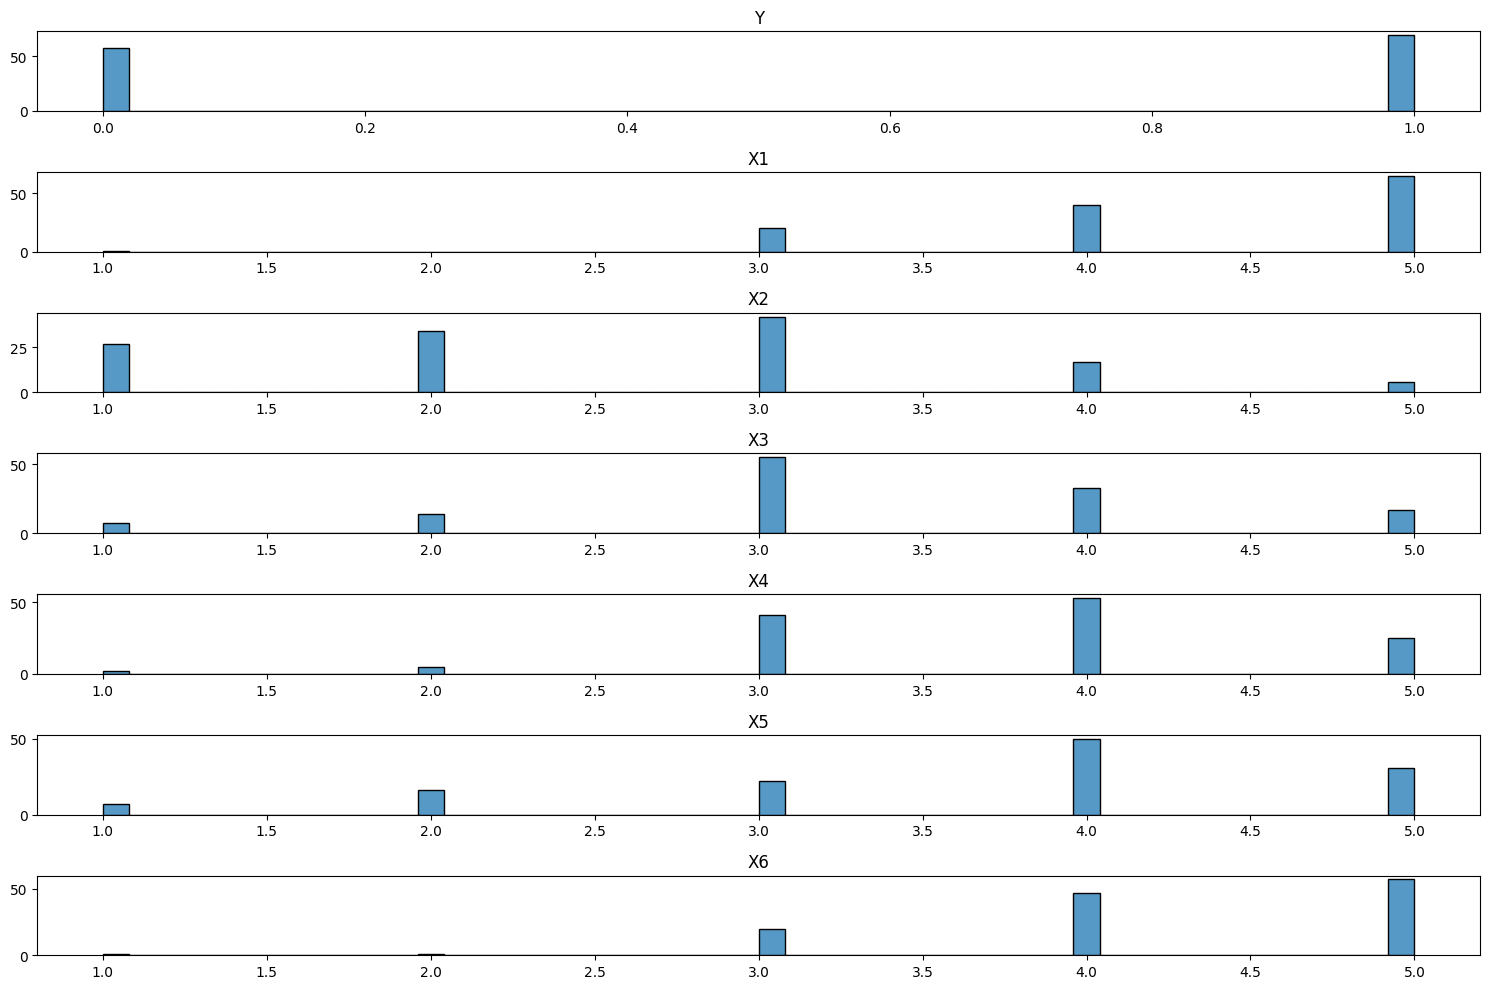

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(figsize=(15,10), ncols=1, nrows=7)
axes = axes.flatten()

for i, ax in enumerate(axes):
    sns.histplot(data = df.iloc[:, i], bins=50, ax=ax)
    ax.set_title(df.iloc[:,i].name)
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

comments: data for Y is not imbalanced, which is good.
X1 skewed to right, 
X2 slightly skewed to left, 
X3 fairly normal, 
X4 skewed to right, 
X5 and X6 skewed to right. Also, there are so few X1 = 1,2 and X6 = 1,2 instances that these cases may not be useful.

In [11]:
df["X1"].value_counts()

X1
5    65
4    40
3    20
1     1
Name: count, dtype: int64

In [12]:
df["X6"].value_counts()

X6
5    57
4    47
3    20
2     1
1     1
Name: count, dtype: int64

Correlation table. It seems that X2 and X4 variables may not be useful for predicting Y. May want to drop them to work in a lower dimension space.

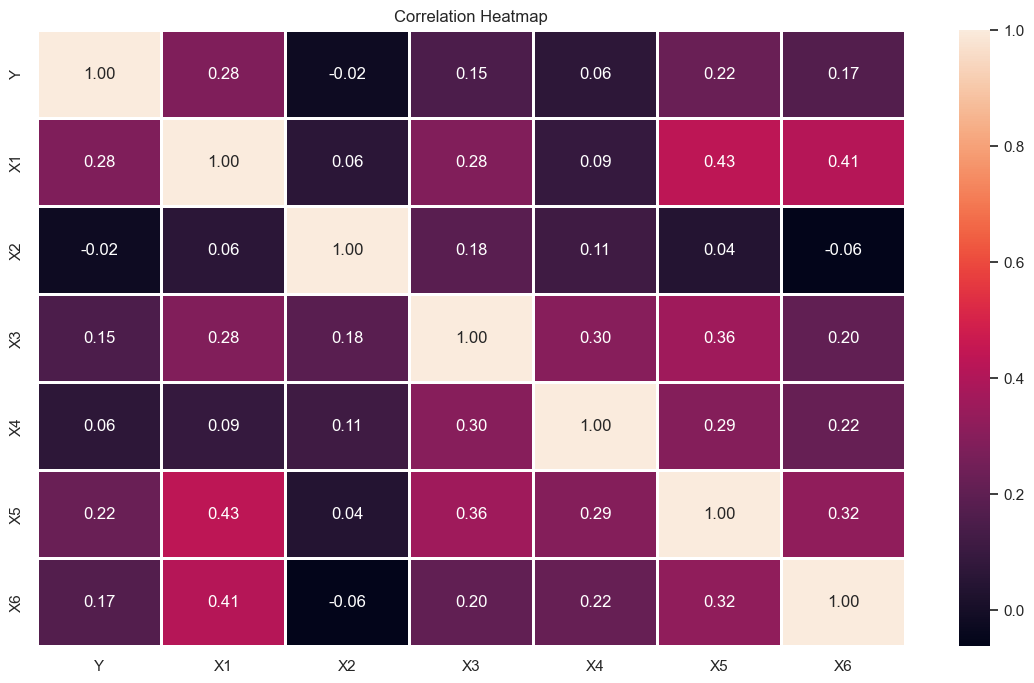

In [13]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(df.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

Data clean up/feature engineering

In [14]:
X = df.drop('Y', axis = 1)
Y = df["Y"].copy()

Model. As it's a classification problem, some models are logistic regression, SVMs, decision tree models. Will try some form of regularization as well. As we want our model to be interpretable, using neural networks would not be adviseable.

Question: No validation set, as goal is 70+% accuracy on whole data set? 

Logistic Regression

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features


In [14]:
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=123)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)


100%|██████████| 32/32 [00:06<00:00,  4.62it/s]

[LightGBM] [Info] Number of positive: 34, number of negative: 29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539683 -> initscore=0.159065
[LightGBM] [Info] Start training from score 0.159065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)

X_ = X.drop('X2', axis = 1)
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, Y, test_size=0.3, random_state=123)



In [30]:

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False, header=True)
y_test.to_csv("y_test.csv", index=False, header=True)

X_train_.to_csv("X_train_.csv", index=False)
X_test_.to_csv("X_test_.csv", index=False)
y_train_.to_csv("y_train_.csv", index=False, header=True)
y_test_.to_csv("y_test_.csv", index=False, header=True)


In [31]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")

y_train = pd.read_csv("y_train.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test = pd.read_csv("y_test.csv").squeeze("columns")

X_train_ = pd.read_csv("X_train_.csv")
X_test_ = pd.read_csv("X_test_.csv")

y_train_ = pd.read_csv("y_train_.csv").squeeze("columns")  # Use `squeeze=True` to load as Series
y_test_ = pd.read_csv("y_test_.csv").squeeze("columns")


In [15]:

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:14<00:00,  2.16it/s]

[LightGBM] [Info] Number of positive: 34, number of negative: 29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539683 -> initscore=0.159065
[LightGBM] [Info] Start training from score 0.159065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

After messing around, only thing that makes slight improvement is getting rid of X2 feature. Best model was decision tree. I will try to implement the following tree models: decision tree classifier, bagging classifier and random forest classifier. I will also use a logistic regression model as a baseline.

In [50]:

from sklearn.preprocessing import label_binarize
from imblearn.metrics import specificity_score

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

dtc_pipeline = Pipeline([
    ("model", DecisionTreeClassifier())
])

dtc_param_grid = {
    "model__max_depth": np.arange(3,15,1,dtype = int),
    "model__min_samples_split": np.arange(2,10,1,dtype = int), 
    "model__min_samples_leaf": np.arange(1,8,1,dtype = int),
    "model__class_weight": [None, "balanced"],
    "model__criterion": ["gini", "entropy"], 
    "model__random_state": [42]
}



# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score),  "precision": make_scorer(precision_score), "recall": make_scorer(recall_score),
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "specificity"
grid_search = GridSearchCV(dtc_pipeline, dtc_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(3), 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
accuracy: 0.5928104575163399
specificity: 0.7392857142857143
precision: 0.7723376623376624
recall: 0.4927272727272728
roc_auc: 0.6833279220779221
pr_auc: 0.7984608497563043
f1_score: 0.5830812324929971


In [51]:
feature_names_out = X_train.columns


We then extract the best params here to save them (to avoid losing them due to random effects in our cv etc.)

In [53]:
best_params_dtc = {'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': np.int64(3), 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
dtc_pipeline = Pipeline([
    ("model", DecisionTreeClassifier(**best_params_dtc))
])

dtc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=np.int64(3),
                                        min_samples_leaf=np.int64(2),
                                        min_samples_split=np.int64(2),
                                        random_state=42))])

Visualising tree

In [55]:
# Get a textual representation of the decision tree
from sklearn.tree import export_text
tree_text = export_text(dtc_pipeline[-1], feature_names=feature_names_out, max_depth=3)
print(tree_text)

|--- X1 <= 4.50
|   |--- X6 <= 3.50
|   |   |--- X3 <= 3.50
|   |   |   |--- class: 0
|   |   |--- X3 >  3.50
|   |   |   |--- class: 0
|   |--- X6 >  3.50
|   |   |--- X3 <= 4.50
|   |   |   |--- class: 0
|   |   |--- X3 >  4.50
|   |   |   |--- class: 0
|--- X1 >  4.50
|   |--- X5 <= 3.50
|   |   |--- X6 <= 4.50
|   |   |   |--- class: 0
|   |   |--- X6 >  4.50
|   |   |   |--- class: 0
|   |--- X5 >  3.50
|   |   |--- X3 <= 2.50
|   |   |   |--- class: 1
|   |   |--- X3 >  2.50
|   |   |   |--- class: 1



Feature importance

In [56]:
print(feature_names_out)

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')


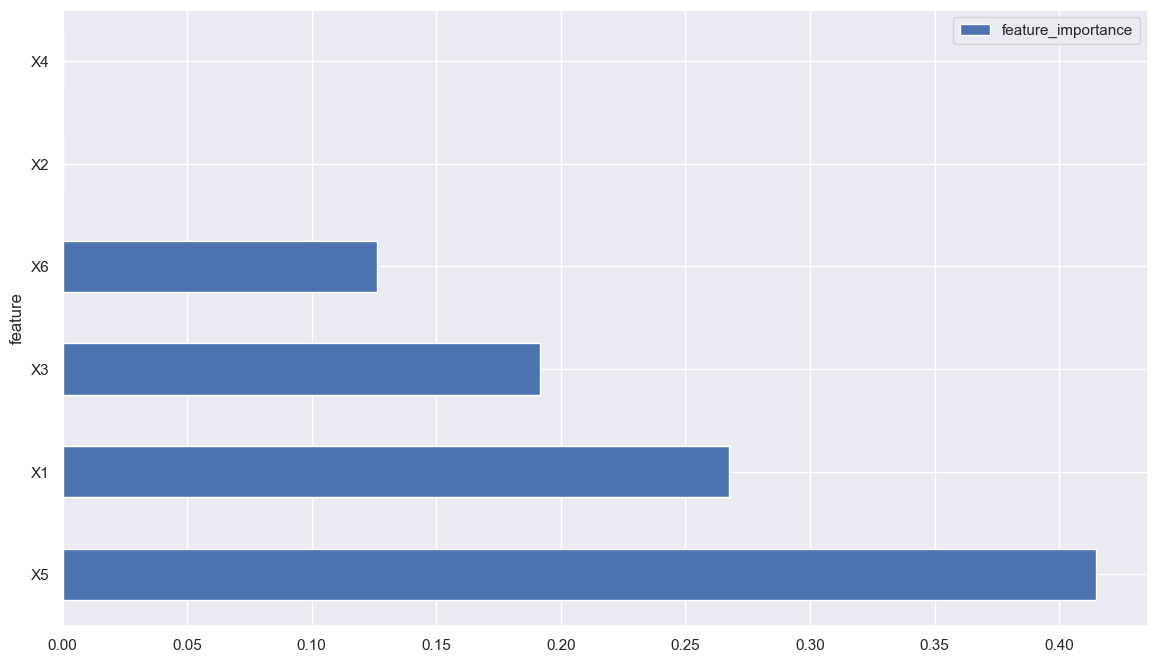

In [57]:
def plot_feature_importance(model, names, threshold = None):
    feature_importance_df = pd.DataFrame.from_dict({'feature_importance': model.feature_importances_[:len(names)],
                                                    'feature': names})\
            .set_index('feature').sort_values('feature_importance', ascending = False)

    if threshold is not None:
        feature_importance_df = feature_importance_df[feature_importance_df.feature_importance > threshold]

    feature_importance_df.plot(kind="barh")
    fig.show()

plot_feature_importance(dtc_pipeline[-1], feature_names_out)

              precision    recall  f1-score   support

           0       0.62      0.65      0.63        20
           1       0.59      0.56      0.57        18

    accuracy                           0.61        38
   macro avg       0.60      0.60      0.60        38
weighted avg       0.60      0.61      0.60        38



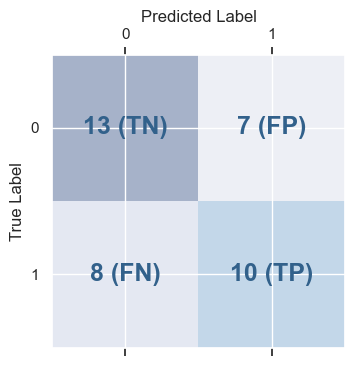

False Positive Rate (FPR): 0.350
Recall: 0.556
Precision: 0.588
F1 Score: 0.571


In [58]:
y_probs = dtc_pipeline.predict_proba(X_test)[:, 1]
y_pred = dtc_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

AUC value: 0.6222222222222222


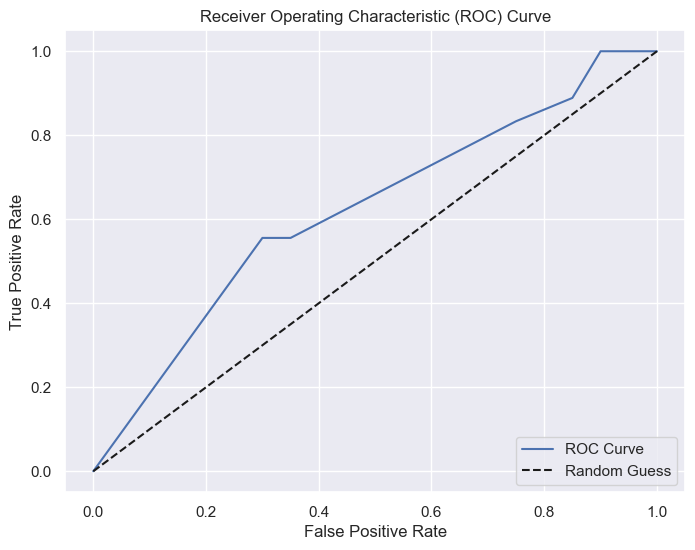

In [59]:
predictions_pa = dtc_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

Bagging Model

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import BaggingClassifier
from imblearn.metrics import specificity_score

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

dtc_pipeline = Pipeline([
    ("model", BaggingClassifier(estimator=DecisionTreeClassifier()))
])

dtc_param_grid = {
    "model__estimator__max_depth": np.arange(8, 11, 1, dtype=int),
    "model__estimator__min_samples_split": np.arange(4, 5, 1, dtype=int),
    "model__estimator__min_samples_leaf": np.arange(1, 4, 1, dtype=int),
    "model__estimator__criterion": ["gini", "entropy"],
    "model__estimator__class_weight": [None, "balanced"], 
    "model__n_estimators": np.arange(10, 30, 10, dtype=int),
    "model__max_samples": [0.5, 0.7, 1.0],
    "model__max_features": [1.0],
    "model__bootstrap": [True, False],
    "model__random_state": [42]
}



# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score),
    "precision": make_scorer(precision_score), "recall": make_scorer(recall_score),
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "specificity"
grid_search = GridSearchCV(dtc_pipeline, dtc_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

KeyboardInterrupt: 

In [32]:
# best model parameters
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=1,
    min_samples_split=7,
    random_state=None
)

# Define the BaggingClassifier with its parameters
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=10,
    max_samples=0.5,
    max_features=1.0,
    bootstrap=False,
    bootstrap_features=False,
    random_state=42
)

# Define the pipeline
bag_pipeline = Pipeline([
    ("model", bagging_model)
])

# Fit the pipeline
bag_pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 BaggingClassifier(bootstrap=False,
                                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=8,
                                                                    min_samples_split=7),
                                   max_samples=0.5, random_state=42))])

Feature Importances:
  Feature  Importance
1      X3    0.241654
4      X6    0.229385
0      X1    0.229201
3      X5    0.201091
2      X4    0.098669


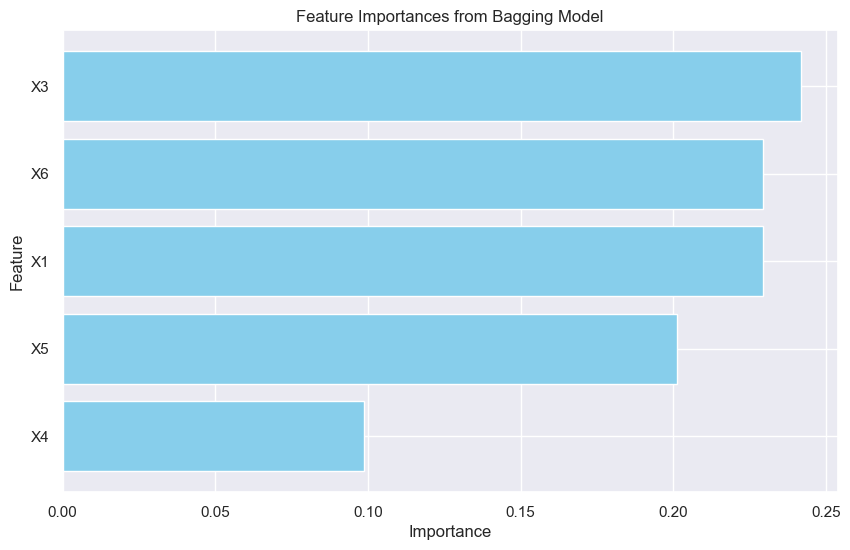

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the BaggingClassifier from the pipeline
bagging_model = bag_pipeline.named_steps["model"]

# Check if the base estimator has feature importances
if hasattr(bagging_model.estimators_[0], "feature_importances_"):
    # Average feature importances across all base estimators
    feature_importances = np.mean(
        [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
    )

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Bagging Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The base estimator does not support feature importances.")


AUC value: 0.5700280112044818


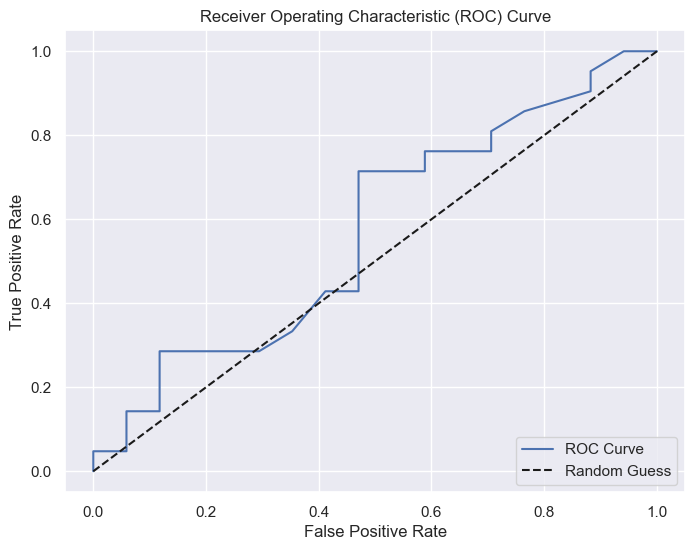

In [35]:
predictions_pa = bag_pipeline.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

              precision    recall  f1-score   support

           0       0.58      0.41      0.48        17
           1       0.62      0.76      0.68        21

    accuracy                           0.61        38
   macro avg       0.60      0.59      0.58        38
weighted avg       0.60      0.61      0.59        38



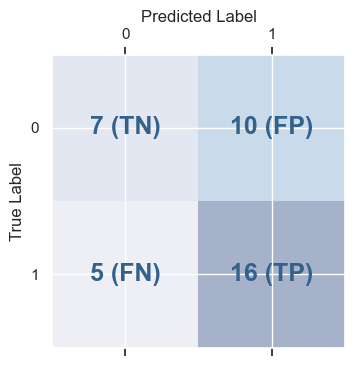

False Positive Rate (FPR): 0.588
Recall: 0.762
Precision: 0.615
F1 Score: 0.681


In [43]:
y_probs = bag_pipeline.predict_proba(X_test)[:, 1]
y_pred = bag_pipeline.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

Random forests

In [62]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier

def custom_roc_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)
    if len(np.unique(y)) > 2:  # Multiclass case
        y_bin = label_binarize(y, classes=np.unique(y))
        return roc_auc_score(y_bin, y_prob, multi_class="ovr", average="macro")
    else:  # Binary case
        return roc_auc_score(y, y_prob[:, 1])

def pr_auc_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def custom_pr_auc_scorer(estimator, X, y):
    y_prob = estimator.predict_proba(X)[:, 1]
    return pr_auc_score(y, y_prob)

rf = Pipeline([
    ("model", RandomForestClassifier())
])

rf_param_grid = {
    "model__n_estimators": [10],  # Number of trees in the forest
    "model__max_depth": [None] + list(np.arange(8, 10, 1)),  # Maximum depth of trees
    "model__min_samples_split": np.arange(4, 6, 1),  # Minimum samples required to split
    "model__min_samples_leaf": np.arange(1, 4, 1),  # Minimum samples required at a leaf node
    "model__max_features": ["sqrt", "log2", None],  # Number of features to consider for the best split
    "model__criterion": ["gini", "entropy"],
    "model__max_samples": [0.5, 0.7, 1.0],
    "model__bootstrap": [True, False],  # Whether to bootstrap samples
    "model__class_weight": [None, "balanced"],  # Adjust weights for imbalanced classes
    "model__random_state": [42]  # Random state for reproducibility
}


# Define custom scoring functions for precision and recall
scoring = {
    "accuracy": make_scorer(accuracy_score), 
    "specificity": make_scorer(specificity_score), 
    "precision": make_scorer(precision_score), "recall": make_scorer(recall_score),
    "roc_auc": custom_roc_auc_scorer,
    "pr_auc": custom_pr_auc_scorer, "f1_score": make_scorer(f1_score)
}

# Define StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

refit = "specificity"
grid_search = GridSearchCV(rf, rf_param_grid, cv=skf, scoring=scoring, refit=refit)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_index = grid_search.best_index_
#feature_names_out = best_model[:-1].get_feature_names_out()
feature_names_out = X_train.columns


print(f"Best parameters: {best_model[-1].get_params()}")

for score_name in scoring:
    score_value = grid_search.cv_results_[f"mean_test_{score_name}"][best_index]
    print(f"{score_name}: {score_value}")

Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(4), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
accuracy: 0.6366013071895424
specificity: 0.6214285714285714
precision: 0.7271212121212122
recall: 0.6472727272727272
roc_auc: 0.6410551948051948
pr_auc: 0.7440052211603013
f1_score: 0.6740981240981241


In [63]:
best_params_bag = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': 0.5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(4), 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


rf = Pipeline([
    ("model", RandomForestClassifier())
])

rf.fit(X_train, y_train)

Pipeline(steps=[('model', RandomForestClassifier())])

Feature Importances:
  Feature  Importance
2      X3    0.190110
4      X5    0.189912
0      X1    0.168501
1      X2    0.161208
5      X6    0.156775
3      X4    0.133494


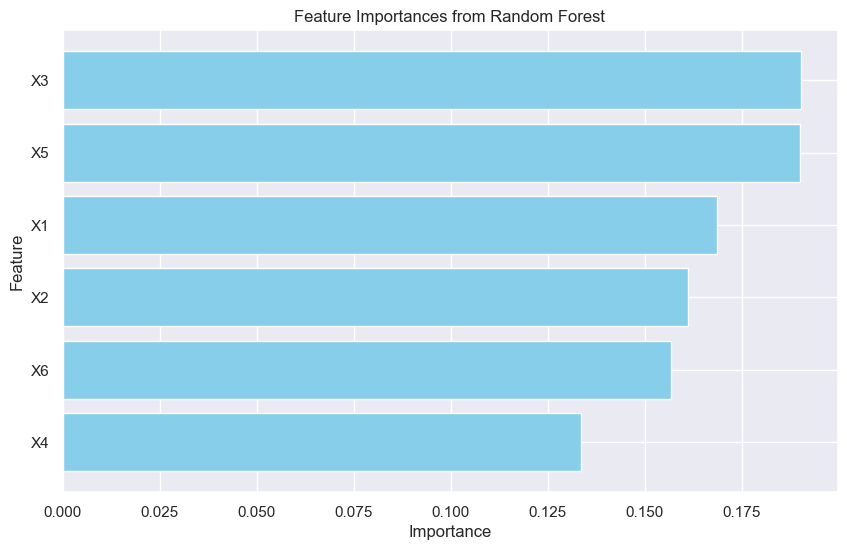

In [64]:
# Extract the RandomForestClassifier from the pipeline
rf_model = rf.named_steps["model"]

# Check if the model has feature_importances_ attribute
if hasattr(rf_model, "feature_importances_"):
    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importance ranking
    feature_names = X_train.columns  # Replace with the actual feature names
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    # Print feature rankings
    print("Feature Importances:")
    print(importance_df)

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Feature Importances from Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The model does not support feature importances.")


              precision    recall  f1-score   support

           0       0.54      0.35      0.42        20
           1       0.48      0.67      0.56        18

    accuracy                           0.50        38
   macro avg       0.51      0.51      0.49        38
weighted avg       0.51      0.50      0.49        38



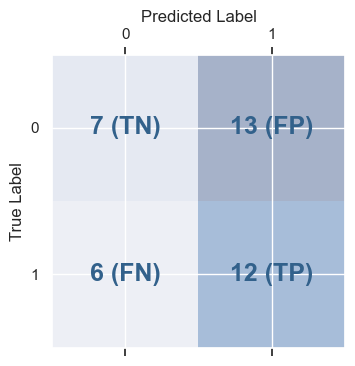

False Positive Rate (FPR): 0.650
Recall: 0.667
Precision: 0.480
F1 Score: 0.558


In [65]:
y_probs = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)

# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)

print(classification_report(y_test, y_pred))

pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

logistic regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform

# Create Logistic Regression pipeline
log_pipe = Pipeline([
    ("model", LogisticRegression(random_state=42, max_iter=200))
])

# List of possible values for C using loguniform distribution
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr += 2

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Create a specificity scorer using make_scorer
specificity_scorer = make_scorer(specificity_score)


scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "recall": "recall",
    "precision": "precision",
    "specificity": specificity_scorer 
}

# Define parameter distribution for RandomizedSearchCV
log_param_dist = {
    'model__C': loguniform(C_list[0], C_list[-1]),  # Regularization strength
    'model__penalty': ['none', 'l1', 'l2'],  # No regularization, L1, and L2 regularization
    'model__class_weight': [None, "balanced"]  # Class weight options
}

# RandomizedSearchCV with multiple scoring metrics
os_log_rs = RandomizedSearchCV(log_pipe, param_distributions=log_param_dist, n_iter=60, 
                               scoring=scoring,
                               cv=StratifiedKFold(n_splits=5), refit="specificity", 
                               random_state=42, return_train_score=True)

# Fit the model
os_log_rs.fit(X_train, y_train)

# Print best parameters and results
print(f"Best parameters found: {os_log_rs.best_params_}")
print(f"Best score (specificity): {os_log_rs.best_score_}")


Best parameters found: {'model__C': np.float64(0.05967677008623393), 'model__class_weight': 'balanced', 'model__penalty': 'l2'}
Best score (specificity): 0.6142857142857142


In [71]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_specificity", ascending=False)[
    ["param_model__C", "param_model__class_weight",
    "mean_test_accuracy", "mean_test_recall", "mean_test_f1", "mean_test_specificity"]].head()

,param_model__C,param_model__class_weight,mean_test_accuracy,mean_test_recall,mean_test_f1,mean_test_specificity
10,0.059677,balanced,0.624837,0.629091,0.658480,0.614286
17,0.121030,balanced,0.613725,0.629091,0.651111,0.589286
39,113.453378,balanced,0.568627,0.610909,0.619198,0.507143
32,1393.884577,balanced,0.568627,0.610909,0.619198,0.507143
4,129.993911,balanced,0.568627,0.610909,0.619198,0.507143


AUC value: 0.5402777777777777


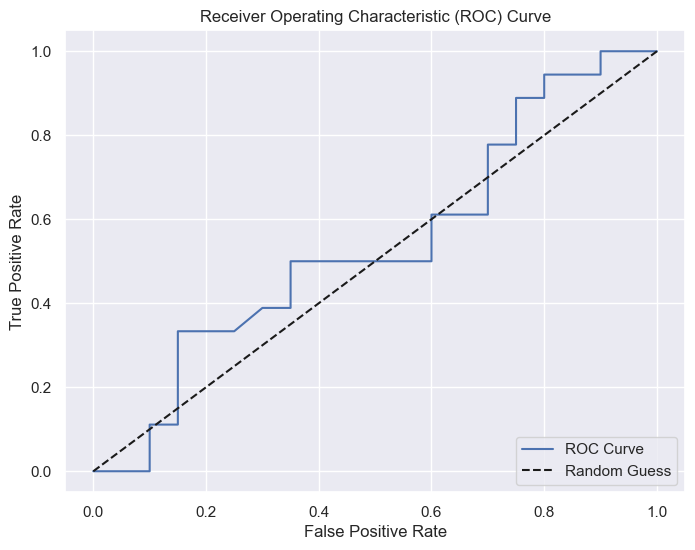

In [72]:
predictions_pa = os_log_rs.predict_proba(X_test)

roc_calc = roc_curve(y_true = y_test, y_score = predictions_pa[:,1])
roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)
print("AUC value:", roc_auc_score(y_true = y_test, y_score = predictions_pa[:,1]))

# Compute precision-recall curve
baseline_precision, baseline_recall, thresholds = precision_recall_curve(y_test, predictions_pa[:,1])

# Compute area under the curve (AUC)
baseline_auc_score = auc(baseline_recall, baseline_precision)

plot_roc_curve(roc)

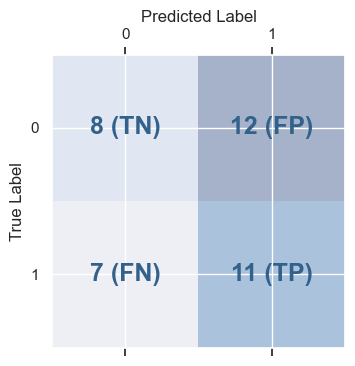

False Positive Rate (FPR): 0.600
Recall: 0.611
Precision: 0.478
F1 Score: 0.537


In [73]:
# get the confusion matrix as a numpy array
confmat = confusion_matrix(y_true = y_test, y_pred = os_log_rs.predict(X_test))
# use the pretty function to make it nicer

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)
y_test = LE.transform(y_test)
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]

# Extracting the quantities from the confusion matrix 
FP = confmat[0,1]
TN = confmat[0,0]
TP = confmat[1,1]
FN = confmat[1,0]

#Calculation of FPR, Recall, Precision and F1 Score
# FPR
FPR = (FP)/(FP+TN)
# Recall
Recall = (TP)/(TP+FN)
# Precision
Precision = (TP)/(FP+TP)
# F1 Score
F1 = 2 * (Precision * Recall)/(Precision + Recall)


pretty_confusion_matrix(confmat, LE.classes_, "",
                        labeling=True, highlight_indexes = [FP_i,FN_i,TP_i,TN_i])

print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: '+ '%.3f' % F1)

In [74]:
best_model = os_log_rs.best_estimator_

# Accessing the coefficients of the logistic regression model
coefficients = best_model.named_steps['model'].coef_[0]

print("Coefficients of the best logistic regression model:")
print(coefficients)
print('Intercept of the best logistic regression model:')
print(coefficients[0])

Coefficients of the best logistic regression model:
[ 0.22881131 -0.00578532  0.20848359 -0.04577755  0.23181849  0.15422497]
Intercept of the best logistic regression model:
0.22881131301555052


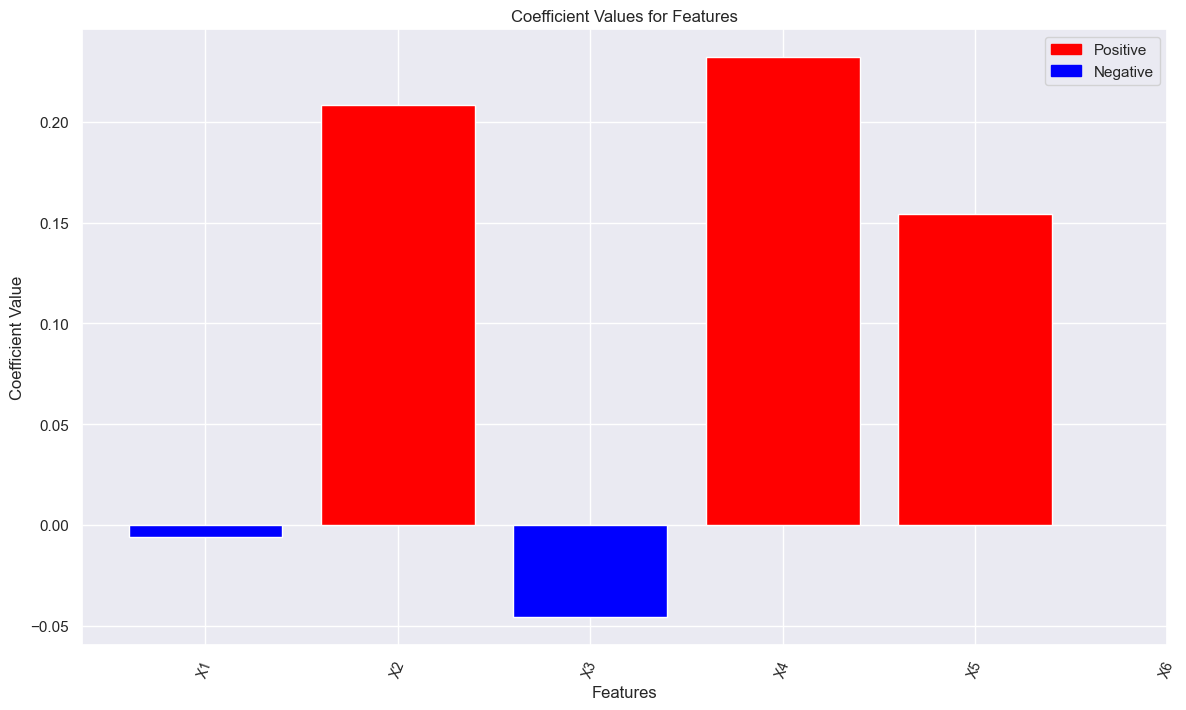

In [75]:
plot_coefs(coefficients[1:], feature_names, 'Coefficient Values for Features')
